In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner
from astropy.cosmology import Flatw0waCDM

In [40]:
# Astropy.cosmology version.Here I am using FlatwowaCDM because it has less parameters.(no Ode)
def Hz1(z1,H01,Om1,w01,wa1):
    cosmo =Flatw0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01,wa=wa1) 
    #the redshift dependence of the dark energy density:
    I = cosmo.de_density_scale(z1)
    E = np.sqrt((Om1*(1+z1)**3.) + (1.-Om1)*I)
    HZ1 = H01*E
    return HZ1

In [41]:
#Define  random redshifts
num_zs = 1000
zs= np.linspace(0.01,6., num=num_zs)

In [42]:
#O_m= 0.291
#w_0= -0.961
#w_1= -0.28
#H_0= 74

In [43]:
#From Planck observations for CPL mode
O_m=0.3029
w_0=-0.9414
w_1=-2.
H_0=68.5265

In [44]:
#Hubble comoving parameter
Hz=Hz1(zs,H_0,O_m,w_0,w_1)/(1+zs)

In [45]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)

In [46]:
H_zz= Hz + e1

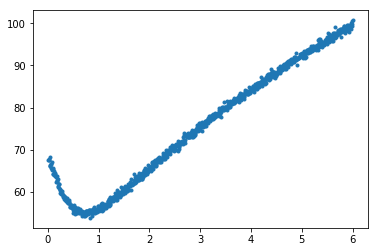

In [47]:
plt.plot(zs,H_zz, '.')

In [48]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.,True,50.,100.),
           ('w01',-1.,True,-3.,3.),
           ('wa1',-0.1,True,-2.,2.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])/(1+zs)-H_zz)/error_sigma

In [27]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 1000
    # variables        = 4
    chi-square         = 1017.43618
    reduced chi-square = 1.02152226
    Akaike info crit   = 25.2859096
    Bayesian info crit = 44.9169307
[[Variables]]
    Om1:  0.30090216 +/- 0.00158489 (0.53%) (init = 0.3)
    H01:  68.7691814 +/- 0.17838279 (0.26%) (init = 70)
    w01: -0.95582724 +/- 0.02222463 (2.33%) (init = -1)
    wa1: -1.98422558 +/- 0.08885786 (4.48%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om1, H01) = -0.996
    C(w01, wa1) = -0.948
    C(Om1, w01) =  0.854
    C(H01, w01) = -0.849
    C(Om1, wa1) = -0.724
    C(H01, wa1) =  0.709


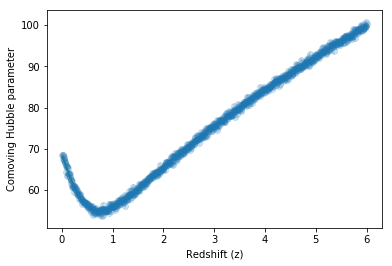

In [28]:
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01,bestwa1)/(1+zs))
plt.plot(zs,Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [16]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

emcee: Exception while calling your likelihood function:
  params: [ 0.30000911 69.99494636 -0.99978993 -0.09999103]
  args: (<function residual at 0x7f6251971578>, Parameters([('Om1', <Parameter 'Om1', 0.3000091096751557, bounds=[0.0:2.0]>), ('H01', <Parameter 'H01', 69.99494636388287, bounds=[50.0:100.0]>), ('w01', <Parameter 'w01', -0.9997899279414466, bounds=[-3.0:3.0]>), ('wa1', <Parameter 'wa1', -0.09999102836915957, bounds=[-2.0:2.0]>)]), ['Om1', 'H01', 'w01', 'wa1'], array([[  0.,   2.],
       [ 50., 100.],
       [ -3.,   3.],
       [ -2.,   2.]]))
  kwargs: {'nan_policy': 'omit', 'userkws': {}, 'userargs': [], 'is_weighted': True, 'float_behavior': 'posterior'}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/alexandra/.local/lib/python2.7/site-packages/lmfit/minimizer.py", line 2015, in _lnpost
    out = userfcn(params, *userargs, **userkwargs)
  File "<ipython-input-13-dd9fcef6d492>", line 9, in residual
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])/(1+zs)-H_zz)/error_sigma
  File "<ipython-input-2-e69a33b13a38>", line 3, in Hz1
    cosmo =Flatw0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,w0=w01,wa=wa1)
  File "/home/alexandra/.local/lib/python2.7/site-packages/astropy/units/core.py", line 721, in __rmul__
    if hasattr(m, 'unit'):
KeyboardInterrupt


KeyboardInterrupt: 

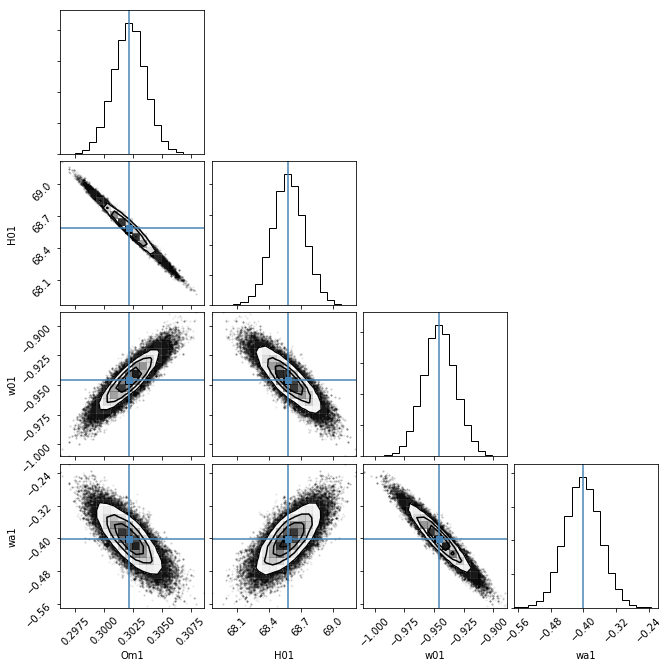

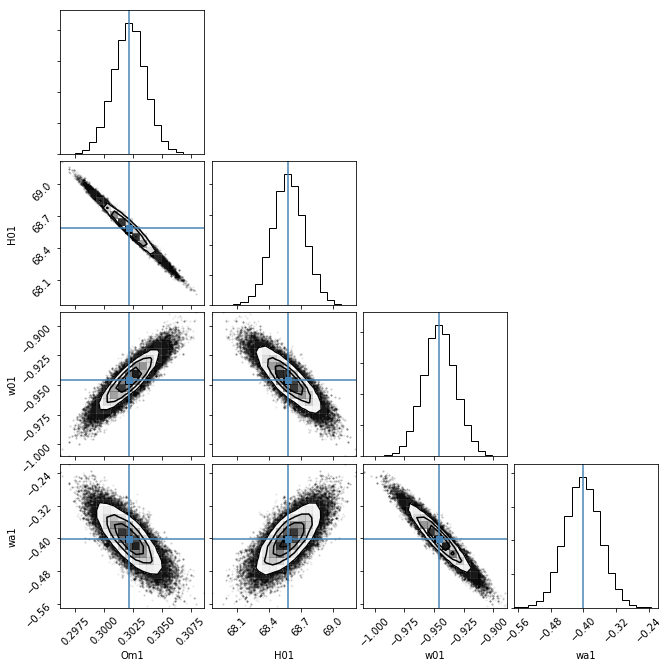

In [24]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [ ]:
# plt.plot(res.flatchain.H01)
plt.plot(res.flatchain.wa1)